# Grid Map Plotting Tool

In [1]:
#Setup
import numpy as np
from pylab import *
from scipy import signal
from scipy import interpolate
from scipy import integrate
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import pandas as pd
import os
import sys
import configparser
import codecs
import csv
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

mpl.rcParams['agg.path.chunksize'] = 100000

In [57]:
#Setup (Visual)
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style('whitegrid')

plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams['figure.facecolor'] = 'white'

#colormap settings
cmap = plt.cm.plasma
cmap2 = plt.cm.Greens

### SETTINGS

In [131]:
#csv data読み込み用
def csv_df(sensor):
    return pd.read_csv(sensor+'.csv', skiprows=1,index_col=False)

#text data読み込み用
def txt_df(sensor):   
    return pd.read_table(sensor+'.txt', header=0,index_col=False)


#Standard methond by rpm and vane position discrimination
def text_plot_ind1(case):
    df_b = txt_df(case)
    vanepos = list()
    rpms = list()
    mapdata = list()
    mapcounts=list()
    count=0
    for g, data in df_b.groupby(['Vane','RPM corr [1/min]']):
        mapdata.append(data)
        vanepos.append(data['Vane'].iloc[0])
        rpms.append(data['RPM corr [1/min]'].iloc[0])
        mapcounts.append(count)
        count+=1
    maxrpmcorr=max(rpms)
    print(maxrpmcorr)
    custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
        Line2D([0], [0], color=cmap(.2), lw=4),
        Line2D([0], [0], color=cmap(.4), lw=4),
        Line2D([0], [0], color=cmap(.6), lw=4),
        Line2D([0], [0], color=cmap(.8), lw=4),
        Line2D([0], [0], color=cmap(1.), lw=4)]
    custom_lines2 = [Line2D([0], [0], color=cmap2(0.), lw=4),
        Line2D([0], [0], color=cmap2(.2), lw=4),
        Line2D([0], [0], color=cmap2(.4), lw=4),
        Line2D([0], [0], color=cmap2(.6), lw=4),
        Line2D([0], [0], color=cmap2(.8), lw=4),
        Line2D([0], [0], color=cmap2(1.), lw=4)]
    clf()
    plt.figure(0)
    plt.title(case)
    plt.ylabel('Flow [g/s]')
    plt.xlabel('Pressure Ratio')
    name = str(case)
    plt.legend(custom_lines, ['0%', '20%', '40%','60%','80%','100%'], title="Vane %") 
    for i in mapcounts:
        xdata = mapdata[i]['ER [ - ]']  #Specify any parameter
        ydata = mapdata[i]['M corr [kg/s]'] #Specify any parameter
        plot(xdata,ydata,color=cmap(vanepos[i]))
    plt.savefig(name + '_ER_Flow_1.png', dpi=300)

    clf()
    plt.figure(0)
    plt.title(case)
    plt.ylabel('Eta %')
    plt.xlabel('Flow [g/s]')
    name = str(case)
    plt.legend(custom_lines, [maxrpmcorr*0., maxrpmcorr*0.2, maxrpmcorr*0.4,maxrpmcorr*0.6,maxrpmcorr*0.8,maxrpmcorr*1.], title="rpm corr") 
    for i in mapcounts:
        xdata = mapdata[i]['M corr [kg/s]']  #Specify any parameter
        ydata = mapdata[i]['eta [fraction]']  #Specify any parameter
        plot(xdata,ydata,color=cmap(rpms[i]/maxrpmcorr))
    plt.savefig(name + '_Flow_Eta_1.png', dpi=300)

    
    
    #Plot 2 axes settings
    clf()
    ax1=plt.figure(0).add_subplot(111)
    plt.title(case)
    ax2 = ax1.twinx() 
    ax1.set_xlabel('Flow [g/s]')
    ax1.set_ylabel('Pressure Ratio')
    ax1.set_ylim(1.0,4.0)
    ax2.set_ylabel('EtaT')
    ax2.set_ylim(0.25,0.85)
    name = str(case)
    
    #Legend
    leg1 = ax1.legend(custom_lines2, ['0%', '20%', '40%','60%','80%','100%'], title="PRT, Vane %", bbox_to_anchor=(1.24,0.9)) 
    leg2 = ax2.legend(custom_lines, [maxrpmcorr*0., maxrpmcorr*0.2, maxrpmcorr*0.4,maxrpmcorr*0.6,maxrpmcorr*0.8,maxrpmcorr*1.], title="EtaT, rpm corr", bbox_to_anchor=(1.07,0.5))
    ax2.grid(None, axis='y')
    
    #Set graph size
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    ax2.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    
    for i in mapcounts:
        xdata = mapdata[i]['M corr [kg/s]']  
        ydata = mapdata[i]['ER [ - ]']
        y2data = mapdata[i]['eta [fraction]']
        ax1.plot(xdata,ydata,color=cmap2(vanepos[i]),linewidth=0.5)
        ax2.plot(xdata,y2data,color=cmap(rpms[i]/maxrpmcorr),linewidth=0.75)
    plt.savefig(name + '_ER_Flow_Eta1.png', dpi=300)

#syntax: (case_name, notes to add to tile, start position, end position, compare option'y' for yes, shift position for compare, lines jump)    
def text_plot_ind2(case,note,start,end,compare,shift,jump):
    df_b = txt_df(case)
    vanepos = list()
    rpms = list()
    mapdata = list()
    for g, data in df_b.groupby(['Vane','RPM corr [1/min]']):
        mapdata.append(data)
        vanepos.append(data['Vane'].iloc[0])
        rpms.append(data['RPM corr [1/min]'].iloc[0])
    maxrpmcorr=max(rpms)
    custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
        Line2D([0], [0], color=cmap(.2), lw=4),
        Line2D([0], [0], color=cmap(.4), lw=4),
        Line2D([0], [0], color=cmap(.6), lw=4),
        Line2D([0], [0], color=cmap(.8), lw=4),
        Line2D([0], [0], color=cmap(1.), lw=4)]
    custom_lines2 = [Line2D([0], [0], color=cmap2(0.), lw=4),
        Line2D([0], [0], color=cmap2(.2), lw=4),
        Line2D([0], [0], color=cmap2(.4), lw=4),
        Line2D([0], [0], color=cmap2(.6), lw=4),
        Line2D([0], [0], color=cmap2(.8), lw=4),
        Line2D([0], [0], color=cmap2(1.), lw=4)]
  


    #Plot 2 axes settings
    clf()
    ax1=plt.figure(0).add_subplot(111)

    ax2 = ax1.twinx() 
    ax1.set_xlabel('Flow [g/s]')
    ax1.set_ylabel('Pressure Ratio')
    ax1.set_ylim(1.0,3.5)
    ax2.set_ylabel('EtaT')
    ax2.set_ylim(0.55,0.85)
    name = str(case)
    
    #Legend
    #leg1 = ax1.legend(custom_lines2, ['0%', '20%', '40%','60%','80%','100%'], title="PRT, Vane %", bbox_to_anchor=(1.24,0.9)) 
    leg2 = ax2.legend(custom_lines, [maxrpmcorr*0., maxrpmcorr*0.2, maxrpmcorr*0.4,maxrpmcorr*0.6,maxrpmcorr*0.8,maxrpmcorr*1.], title="rpm corr", bbox_to_anchor=(1.25,0.5))
    ax2.grid(None, axis='y')
    
    #Set graph size
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    ax2.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    
    j=start
    while j < end:
        xdata = mapdata[j]['M corr [kg/s]']  
        ydata = mapdata[j]['ER [ - ]']
        y2data = mapdata[j]['eta [fraction]']
        ax1.plot(xdata,ydata,color=cmap(rpms[j]/maxrpmcorr),linewidth=1.0)
        ax2.plot(xdata,y2data,color=cmap(rpms[j]/maxrpmcorr),linewidth=1.0)
        y2list = y2data.tolist()
        ylist=ydata.tolist()
        xlist=xdata.tolist()
        etamax=max(y2list)
        flowmax=max(xlist)
        PRTatEM=ylist[y2list.index(etamax)]
        FlowatEM=xlist[y2list.index(etamax)]
        
        print(rpms[j])
        print(etamax)
        print(PRTatEM)
        print(FlowatEM)
        
        #ax1.plot([0,FlowatEM],[PRTatEM,PRTatEM],color="Blue",linewidth=0.5, linestyle='dashed')
        #ax2.plot([FlowatEM,flowmax+0.02],[etamax,etamax],color="Green",linewidth=0.5, linestyle='dashed')
        #ax2.plot([FlowatEM,FlowatEM],[0,etamax],color="Blue",linewidth=0.5, linestyle='dashed')

        if compare=='y':
            etabase=y2list[shift]
            flowbase=xlist[shift]
            PRTbase=ylist[shift]
            ax1.plot([0,flowbase],[PRTbase,PRTbase],color="Blue",linewidth=0.7, linestyle='dashed')
            ax2.plot([flowbase,flowmax+0.02],[etabase,etabase],color="Green",linewidth=0.7, linestyle='dashed')
            ax2.plot([flowbase,flowbase],[0,etabase],color="Blue",linewidth=0.7, linestyle='dashed')


        j+=jump #change jumping range
    ax1.set_xlim(0,flowmax+0.02)
    plt.title(case+' Vane Pos=:'+str(vanepos[j-1]) )
    plt.savefig(name + '_ER_Flow_Eta2_'+note+'_.png', dpi=300)

    
def text_plot_ind3(case, note,xang,yang):
    df_b = txt_df(case)
    name = str(case)
    vanepos = list()
    rpms = list()
    mapdata = list()
    mapcounts=list()
    count=0
    for g, data in df_b.groupby(['Vane','RPM corr [1/min]']):
        mapdata.append(data)
        vanepos.append(data['Vane'].iloc[0])
        rpms.append(data['RPM corr [1/min]'].iloc[0])
        mapcounts.append(count)
        count+=1
    maxrpmcorr=max(rpms)
    
    custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
    Line2D([0], [0], color=cmap(.2), lw=4),
    Line2D([0], [0], color=cmap(.4), lw=4),
    Line2D([0], [0], color=cmap(.6), lw=4),
    Line2D([0], [0], color=cmap(.8), lw=4),
    Line2D([0], [0], color=cmap(1.), lw=4)]
    
    xdata=list()
    ydata=list()
    zdata=list()
    rpmdata=list()
    j=0
    while j < len(mapcounts):
        xtmp = mapdata[j]['M corr [kg/s]'].to_list()
        ytmp = mapdata[j]['ER [ - ]'].to_list()
        ztmp = mapdata[j]['eta [fraction]'].to_list()
        rpmtmp = mapdata[j]['RPM corr [1/min]'].to_list()
        xdata.append(xtmp)
        ydata.append(ytmp)
        zdata.append(ztmp)
        rpmdata.append(rpmtmp)
        j+=1
        
    fig=plt.figure(figsize=(24,20))
    ax=fig.add_subplot(111,projection='3d')
    ax.view_init(xang, yang)
    ax.set_title("PRT-Flow Eta GridMap")
    ax.set_xlabel("Flow [g/s]")
    ax.set_ylabel("PRT")
    ax.set_zlabel("Eta")
    ax.legend(loc="best")
     #Legend
    leg1=ax.legend(custom_lines, ['0%', '20%', '40%','60%','80%','100%'], title="PRT, Vane %") 
    #leg2=ax.legend(custom_lines, [maxrpmcorr*0., maxrpmcorr*0.2, maxrpmcorr*0.4,maxrpmcorr*0.6,maxrpmcorr*0.8,maxrpmcorr*1.], title="rpm corr")
    
    k=0
    for k in mapcounts:
        ax.plot(xdata[k],ydata[k],zdata[k],color=cmap(rpms[k]/maxrpmcorr),linewidth=0.5)
    plt.savefig(name + '_ER_Flow_Eta3_3D'+note+'_.png', dpi=400)
    
    k=0
    for k in mapcounts:
        ax.plot(xdata[k],ydata[k],rpmdata[k],color=cmap(vanepos[k]),linewidth=0.5)
    ax.set_title("PRT-Flow rpm GridMap")
    ax.set_zlabel("rpm")    
    plt.savefig(name + '_ER_Flow_rpm3_3D'+note+'_.png', dpi=400)
    
    
    
#Alternate mapping method with out discrimination
def text_plot_all(case):
    df_b = txt_df(case)
    clf()
    plt.figure()   
    df_b.set_index('ER [ - ]', inplace=True)   
    ydata_df = df_b.groupby(['RPM corr [1/min]','Vane'])       
   
    for key, item in ydata_df:
        custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                        Line2D([0], [0], color=cmap(.2), lw=4),
                        Line2D([0], [0], color=cmap(.4), lw=4),
                        Line2D([0], [0], color=cmap(.6), lw=4),
                        Line2D([0], [0], color=cmap(.8), lw=4),
                        Line2D([0], [0], color=cmap(1.), lw=4)]
        plt.legend(custom_lines, ['0%', '20%', '40%','60%','80%','100%']) 
        col=cmap(float(key[1]))
        ydata_df.get_group(key)['M corr [kg/s]'].plot(legend=False,color=col)
    plt.title('PRT-Flow plot for ' + case)
    plt.ylabel('Flow [kg/s]')
    plt.xlabel('PRT')
    name = str(case)
    plt.savefig(name + '_PRT_Flow_vane.png', dpi=300)

### Plot Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


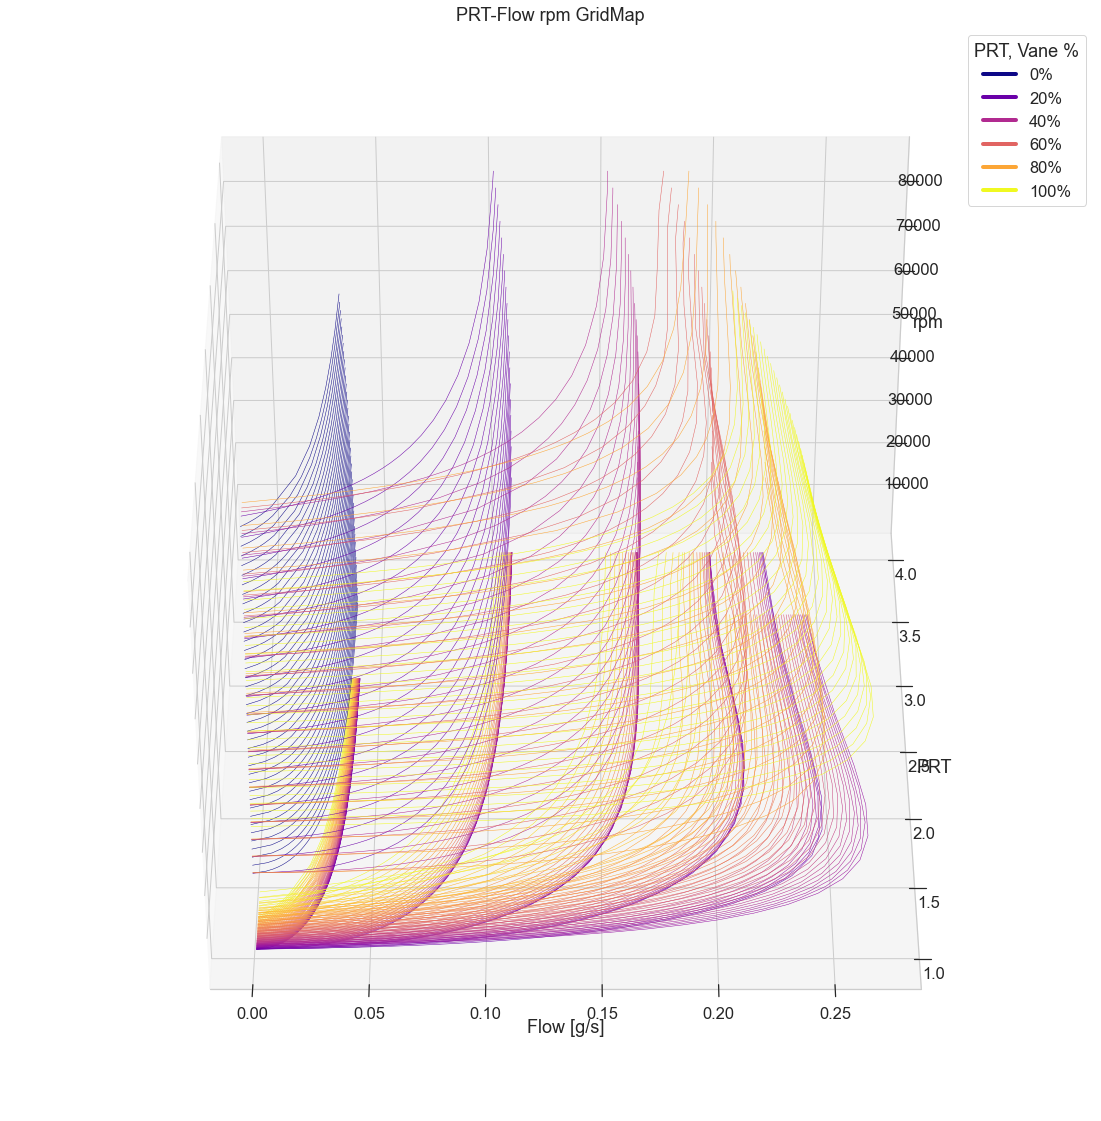

In [133]:
#text_plot_ind1('T322(70)Tr64AR1.15vh7.5_GRIDMAP')
#text_plot_ind2('T322(70)Tr64AR1.15vh7.5_GRIDMAP','60p_all',60,80,'n',0,1)
print()
#text_plot_ind2('T322(70)Tr64AR1.15vh7.5_GRIDMAP','60p_5',50,71,'n',15,20)
text_plot_ind3('T322(70)Tr64AR1.15vh7.5_GRIDMAP','note',30,250)


